## The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

### Set Up Notebooks for Analysis and Import required libraries

In [1]:
# Import required packages
import pandas as pd
import numpy as np
import time
import subprocess
import sys
from IPython.display import display

# Import scikit-learn packages
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

# Import torch and transformers
import torch
from transformers import pipeline

# Import spacy
import spacy
from spacy.util import is_package

# Visualization library
import matplotlib.pyplot as plt
import seaborn as sns


/Users/biitu/Documents/Code/Learn/Udacity Masters/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL = "en_core_web_sm"

# Download only if not available
if not is_package(MODEL):
    subprocess.check_call([
        sys.executable, "-m", "spacy", "download", MODEL
    ])

# Load the model
nlp = spacy.load(MODEL)

## Load Data

In [3]:
# Load data from reviews.csv
df = pd.read_csv('data/reviews.csv',)

In [4]:
# Shape of the dataframe
print("Shape:", df.shape)

Shape: (18442, 9)


#### The data has 18442 records and 9 fields, including 8 features and 1 target field.

In [5]:
# Features and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


#### The dataset doesn't contain any empty cells.

In [6]:
# First five rows of the dataset
df.head()

,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


## Helper functions to visualise the data

In [7]:
# Creates a histogram of a dataframe
def plot_histogram(data, title, bins=10):
    """
    Plot a histogram for a pandas Series or histograms for numeric columns
    in a pandas DataFrame.

    This function adapts automatically based on the input type:
    - Series  → single histogram
    - DataFrame → grid of histograms for numeric columns

    Parameters
    ----------
    data : pandas.Series or pandas.DataFrame
        Input data to visualize.
    title : str
        Title displayed above the histogram plot.
    bins : int, default=10
        Number of bins to use for the histogram(s).

    Returns
    -------
    None
        Displays the histogram plot(s).
    """
    # Defensive checks
    if data is None or data.empty:
        raise ValueError("Input data is empty or None.")

    if not isinstance(bins, int) or bins <= 0:
        raise ValueError("`bins` must be a positive integer.")

    # Create the histogram
    plt.figure(figsize=(8, 5))
    plt.hist(data.dropna(), bins=bins, edgecolor="black")
    plt.title(title, fontsize=14)
    plt.xlabel(data.name or "Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Creates a heatmap of the correlation matrix using seaborn 
def plot_correlation_heatmap(corr_df, title):
    """
    Plot a correlation heatmap using Seaborn.

    This function visualizes the pairwise correlations between numeric
    features in a DataFrame using a color-encoded heatmap.

    Parameters
    ----------
    corr_df : pandas.DataFrame
        A square correlation matrix (typically produced by df.corr()).
    title : str
        Title displayed above the heatmap.

    Returns
    -------
    None
        Displays the heatmap.
    """
    # Validate input
    if corr_df is None or corr_df.empty:
        raise ValueError("Correlation DataFrame is empty or None.")

    if corr_df.shape[0] != corr_df.shape[1]:
        raise ValueError("Input must be a square correlation matrix.")

    # Create the heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(
        corr_df,
        annot=True,
        fmt=".2f",
        cmap="rocket",
        linewidths=0.5,
        square=True
    )

    # Add title and improve layout
    plt.title(title, fontsize=16)
    plt.tight_layout()

    # Render plot
    plt.show()

    

## Examine the correlations of features by creating a correlation matrix and a heatmap for numeric features.

In [8]:
# A numeric-only copy of the dataset
data_num = df.drop(columns=["Title", "Review Text"]).copy()

# Initialize ordinal encoder
ordinal_encoder = OrdinalEncoder()

# Identify categorical (object-type) columns
cat_cols = data_num.select_dtypes(include="object").columns

# Fit and transform all categorical columns at once
data_num[cat_cols] = ordinal_encoder.fit_transform(data_num[cat_cols])

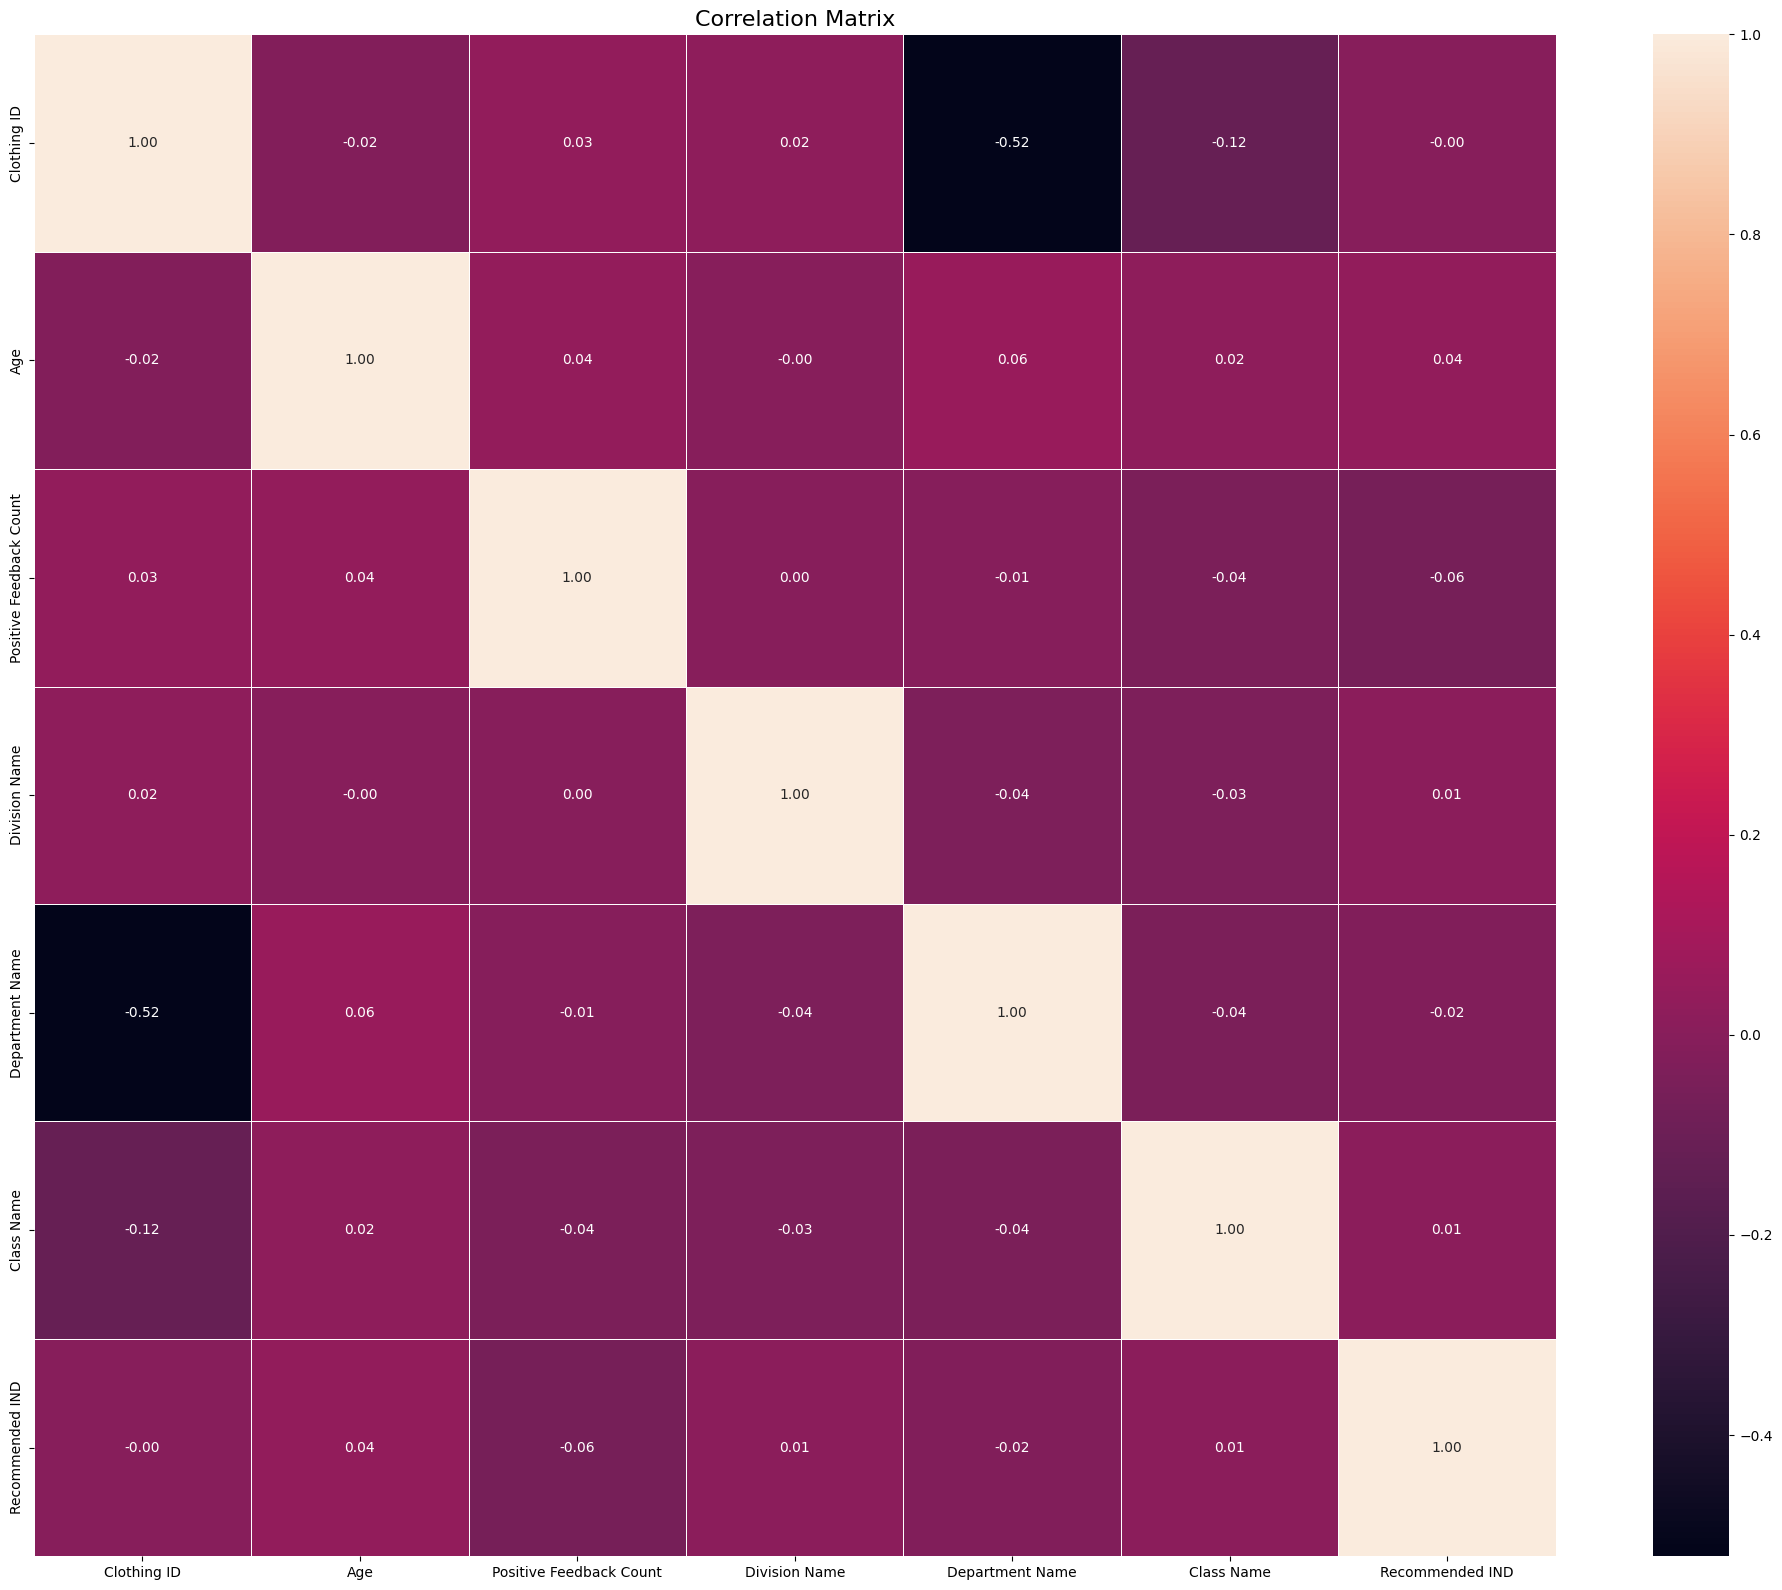

In [9]:
# calculate the correlation matrix
corr_matrix = data_num.corr()

# plot the correlation matrix
plot_correlation_heatmap(corr_matrix, 'Correlation Matrix')

In [10]:
# Print the correlation matrix sorted by linear correlation
corr_matrix["Recommended IND"].sort_values(ascending=False)

Recommended IND            1.000000
Age                        0.036656
Class Name                 0.010550
Division Name              0.008875
Clothing ID               -0.000180
Department Name           -0.024077
Positive Feedback Count   -0.058392
Name: Recommended IND, dtype: float64

#### The correlation matrix and heatmap show that age and class name have the strongest association with a product being recommended.

## Examine the top 3 features with the strongest correlation to being recommended using histograms

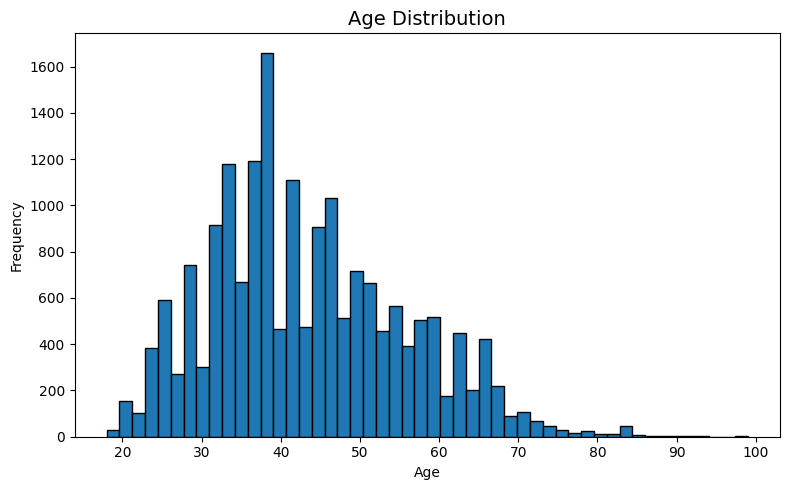

In [11]:
# Histogram showing customer age distribution
plot_histogram(df['Age'], 'Age Distribution', 50)

#### The histogram shows us most customers are in their 30s and the bulk of customers under 50.

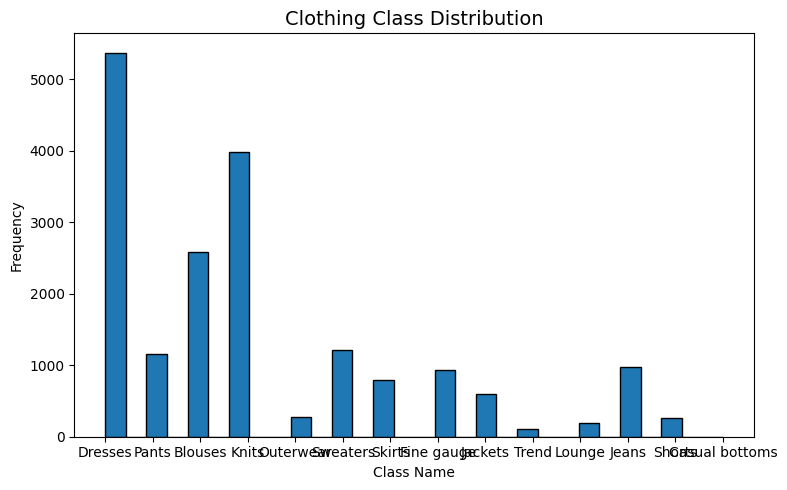

In [12]:
# Histogram showing clothing type (Class Name) distribution
plot_histogram(df['Class Name'], 'Clothing Class Distribution', 30)

#### The histogram shows us the most popular items are dresses, knits, and blouses.

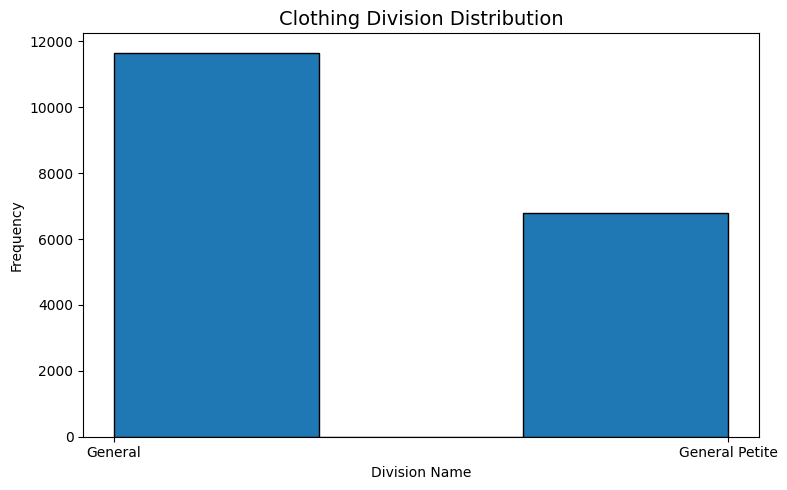

In [13]:
# Histogram showing clothing type (Class Name) distribution
plot_histogram(df['Division Name'], 'Clothing Division Distribution', 3)

#### The histogram shows us general sized items are almost twice as popular as petite items.

# Prepare Data
* Prepare data for pipeline modeling

## Split data into numerical, categorical, and text features
* 'Clothing ID' more of a category than a numerical feature

In [14]:
# Numerical columns
num_features = ['Age', 'Positive Feedback Count']
print('Numerical features:', num_features)


Numerical features: ['Age', 'Positive Feedback Count']


In [15]:
# Categorical columns
cat_features = ['Clothing ID', 'Division Name', 'Department Name', 'Class Name']
print('Categorical features:', cat_features)

Categorical features: ['Clothing ID', 'Division Name', 'Department Name', 'Class Name']


In [16]:
# Combine text columns into a single review column
df["Review"] = df["Title"].astype(str) + " " + df["Review Text"].astype(str)

# Drop the original text columns
df.drop(columns=["Title", "Review Text"], inplace=True)

# Define text features for downstream NLP processing
text_features = ["Review"]

print(f"Text features: {text_features}")

Text features: ['Review']


## Preparing features (`X`) & target (`y`)

In [17]:
data = df

# separate features from labels
X = data.drop('Recommended IND', axis=1)
y = data['Recommended IND'].copy()

print('Labels:', y.unique())
print('Features:')
display(X.head())

Labels: [0 1]
Features:


,Clothing ID,Age,Positive Feedback Count,Division Name,Department Name,Class Name,Review
0,1077,60,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...
1,1049,50,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps..."
2,847,47,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...
3,1080,49,4,General,Dresses,Dresses,Not for the very petite I love tracy reese dre...
4,858,39,1,General Petite,Tops,Knits,Cagrcoal shimmer fun I aded this in my basket ...


In [18]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

# Building Pipeline
* Preprocess data and create a model using random forest classifier

### Numerical Features

#### Preprocssing pipeline for numerical features

In [19]:
# Preprocessing pipeline for numerical features
num_pipeline = Pipeline(
    steps=[
        # Handle missing values by replacing them with the column mean
        ("imputer", SimpleImputer(strategy="mean")),

        # Scale features to the [0, 1] range
        ("scaler", MinMaxScaler()),
    ]
)

num_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('scaler', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'mean'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If a fea

### Categorical Features

#### Preprocssing pipeline for categorical features

In [20]:
# Preprocessing pipeline for categorical features
cat_pipeline = Pipeline(
    steps=[
        # Encode categories as ordered integers (handles unseen categories safely)
        ("ordinal_encoder", OrdinalEncoder(
            handle_unknown="use_encoded_value",
            unknown_value=-1
        )),

        # Impute missing values using the most frequent category
        ("imputer", SimpleImputer(strategy="most_frequent")),

        # One-hot encode categorical features for model compatibility
        ("cat_encoder", OneHotEncoder(
            sparse_output=False,
            handle_unknown="ignore"
        )),
    ]
)

cat_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('ordinal_encoder', ...), ('imputer', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"categories categories: 'auto' or a list of array-like, default='auto'Categories (unique values) per feature:- 'auto' : Determine categories automatically from the training data.- list : ``categories[i]`` holds the categories expected in the ith column. The passed categories should not mix strings and numeric values, and should be sorted in case of numeric values.The used categories can be found in the ``categories_`` attribute.",'auto'
,"dtype dtype: number type, default=np.float64Desired dtype of output.",<class 'numpy.float64'>
,"handle_unknown handle_unknown: {'error', 'use_encoded_value'}, default='error'When set to 'error' an error will be raised in case an unknowncategorical feature is present during transform. When set to'use_encoded_value', the encoded value of unknown categories will beset to the value given for the parameter `unknown_value`. In:meth:`inverse_transform`, an unknown category will be denoted as None... versionadded:: 0.24",'use_encoded_value'
,"unknown_value unknown_value: int or np.nan, default=NoneWhen the parameter handle_unknown is set to 'use_encoded_value', thisparameter is required and will set the encoded value of unknowncategories. It has to be distinct from the values used to encode any ofthe categories in `fit`. If set to np.nan, the `dtype` parameter mustbe a float dtype... versionadded:: 0.24",-1
,"encoded_missing_value encoded_missing_value: int or np.nan, default=np.nanEncoded value of missing categories. If set to `np.nan`, then the `dtype`parameter must be a float dtype... versionadded:: 1.1",nan
,"min_frequency min_frequency: int or float, default=NoneSpecifies the minimum frequency below which a category will beconsidered infrequent.- If `int`, categories with a smaller cardinality will be considered infrequent.- If `float`, categories with a smaller cardinality than `min_frequency * n_samples` will be considered infrequent... versionadded:: 1.3 Read more in the :ref:`User Guide `.",None
,"max_categories max_categories: int, default=NoneSpecifies an upper limit to the number of output categories for each inputfeature when considering infrequent categories. If there are infrequent

### Text Features

#### Custom transformers for text features

In [21]:
class SpacyTextLemmatizer(BaseEstimator, TransformerMixin):
    """
    Custom scikit-learn transformer for text lemmatization using spaCy.

    This transformer converts words with similar meanings (e.g., "good",
    "better") into their base lemma form and removes stop words. It is
    designed to be used inside an sklearn Pipeline.
    """

    def __init__(self, nlp):
        """
        Initialize the SpacyTextLemmatizer.

        Parameters
        ----------
        nlp : spacy.language.Language
            A loaded spaCy NLP pipeline (e.g., en_core_web_sm) used
            for tokenization and lemmatization.
        """
        self.nlp = nlp

    def fit(self, X, y=None):
        """
        Fit method (no-op).

        This method exists to comply with the scikit-learn transformer API.
        No fitting is required since spaCy models are pre-trained.

        Parameters
        ----------
        X : iterable of str
            Input text data.
        y : None, optional
            Ignored.

        Returns
        -------
        self : SpacyTextLemmatizer
            The fitted transformer instance.
        """
        return self

    def transform(self, X):
        """
        Transform text data by lemmatizing and removing stop words.

        Parameters
        ----------
        X : iterable of str
            Raw text input.

        Returns
        -------
        list of str
            Lemmatized text with stop words and punctuation removed.
        """
        # Ensure all inputs are strings
        texts = [str(text) for text in X]

        # Lemmatize text efficiently using spaCy's pipe
        lemmatized_texts = [
            " ".join(
                token.lemma_
                for token in doc
                if not token.is_stop and not token.is_punct
            )
            for doc in self.nlp.pipe(texts)
        ]

        return lemmatized_texts

In [22]:
class SpacyPOSNERTransformer(BaseEstimator, TransformerMixin):
    """
    Custom scikit-learn transformer to extract simple linguistic features
    using spaCy Part-of-Speech (POS) tagging and Named Entity Recognition (NER).

    For each input text, the transformer computes:
      - Number of nouns
      - Number of verbs
      - Number of adjectives
      - Number of named entities
    """

    def __init__(self, nlp, batch_size=64):
        """
        Initialize the transformer.

        Parameters
        ----------
        nlp : spacy.language.Language
            A loaded spaCy NLP pipeline (e.g., en_core_web_sm) used to
            process text and extract POS and NER features.
        batch_size : int, default=64
            Batch size used when processing text with spaCy for
            improved performance.
        """
        self.nlp = nlp
        self.batch_size = batch_size

    def fit(self, X, y=None):
        """
        Fit method (no-op).

        This method exists to comply with the scikit-learn transformer API.
        No fitting is required because spaCy models are pre-trained.

        Parameters
        ----------
        X : iterable of str
            Raw text input.
        y : array-like, optional
            Target values (ignored).

        Returns
        -------
        self : SpacyPOSNERTransformer
            The fitted transformer instance.
        """
        return self

    def transform(self, X):
        """
        Transform raw text into POS and NER count features.

        Parameters
        ----------
        X : iterable of str
            Raw text input.

        Returns
        -------
        numpy.ndarray
            A 2D array of shape (n_samples, 4) where each row contains:
            [noun_count, verb_count, adjective_count, named_entity_count]
        """
        features = []

        # Process text efficiently in batches
        for doc in self.nlp.pipe(X, batch_size=self.batch_size):
            noun_count = sum(token.pos_ == "NOUN" for token in doc)
            verb_count = sum(token.pos_ == "VERB" for token in doc)
            adj_count = sum(token.pos_ == "ADJ" for token in doc)
            ner_count = len(doc.ents)

            features.append([
                noun_count,
                verb_count,
                adj_count,
                ner_count
            ])

        return np.array(features)

In [23]:
class TransformerSentimentScorer(BaseEstimator, TransformerMixin):
    """
    scikit-learn transformer that converts raw text into a numeric sentiment score
    using a Hugging Face Transformers sentiment-analysis pipeline.

    Output is a single feature per sample:
      +score for POSITIVE predictions
      -score for NEGATIVE predictions

    Notes
    -----
    - The underlying HF pipeline is cached at the class level so it is initialized
      only once (faster across multiple fit/transform calls).
    - Device selection prefers CUDA, then Apple MPS, else CPU.
    """

    _sent_pipeline = None  # class-level cache (shared across instances)

    def __init__(
        self,
        model_name: str = "distilbert-base-uncased-finetuned-sst-2-english",
        batch_size: int = 64,
        text_column: str = "Review",
    ):
        """
        Parameters
        ----------
        model_name : str, default="distilbert-base-uncased-finetuned-sst-2-english"
            Hugging Face model name for sentiment analysis.
        batch_size : int, default=64
            Batch size passed to the HF pipeline.
        text_column : str, default="Review"
            Column name to read text from when X is a pandas DataFrame.
        """
        self.model_name = model_name
        self.batch_size = batch_size
        self.text_column = text_column

        # Initialize the shared pipeline once for speed
        if TransformerSentimentScorer._sent_pipeline is None:
            if torch.cuda.is_available():
                device = 0
            elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
                device = "mps"
            else:
                device = -1

            TransformerSentimentScorer._sent_pipeline = pipeline(
                "sentiment-analysis",
                model=self.model_name,
                device=device,
            )

    def fit(self, X, y=None):
        """
        Fit method (no-op) to comply with the scikit-learn transformer API.

        Parameters
        ----------
        X : array-like
            Input samples (ignored).
        y : array-like, optional
            Target values (ignored).

        Returns
        -------
        self : TransformerSentimentScorer
            The transformer instance.
        """
        return self

    def transform(self, X):
        """
        Transform input text into a numeric sentiment score feature.

        Parameters
        ----------
        X : pandas.DataFrame or numpy.ndarray or iterable of str
            Input text. Supported formats:
              - DataFrame: text is taken from `self.text_column`
              - ndarray: text is assumed to be in the first column (X[:, 0])
              - iterable: treated as a sequence of text strings

        Returns
        -------
        numpy.ndarray
            Array of shape (n_samples, 1) containing signed sentiment scores.
        """
        # --- Extract texts from common input formats ---
        if isinstance(X, pd.DataFrame):
            texts = X[self.text_column].astype(str).tolist()
        elif isinstance(X, np.ndarray):
            texts = X[:, 0].astype(str).tolist()
        else:
            texts = pd.Series(X).astype(str).tolist()

        # --- Run sentiment model in batches ---
        results = TransformerSentimentScorer._sent_pipeline(texts, batch_size=self.batch_size)

        # --- Convert labels to signed scores (+ for POSITIVE, - for NEGATIVE) ---
        scores = np.array(
            [r["score"] if r["label"] == "POSITIVE" else -r["score"] for r in results],
            dtype=float,
        ).reshape(-1, 1)

        return scores

#### Preprocssing pipeline for text features using SpacyTextLemmatizer

In [24]:
# define a preprocssing pipeline for text features using SpacyTextLemmatizer
tfidf_pipeline = Pipeline([
    (
        'dimension_reshaper',
        FunctionTransformer(
            np.reshape,
            kw_args={'newshape': -1},
        ),
    ),
    (
        'lemmatizer',
        SpacyTextLemmatizer(nlp=nlp),
    ),
    (
        'tfidf_vectorizer',
        TfidfVectorizer(
            stop_words='english',
        ),
    ),
])

tfidf_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('dimension_reshaper', ...), ('lemmatizer', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function res...t 0x10d0266f0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword ar

#### Combine text preprocessors tfidf_pipeline and custom transformer TransformerSentimentScorer

In [25]:
# Combine text preprocessors using ColumnTransformer
text_feature_engineering = FeatureUnion([
    ('tfidf', tfidf_pipeline), 
    ('TransformerSentimentScorer', TransformerSentimentScorer()),
    ('nlp', SpacyPOSNERTransformer(nlp=nlp))
])

text_feature_engineering

Device set to use mps


,"transformer_list transformer_list: list of (str, transformer) tuplesList of transformer objects to be applied to the data. The firsthalf of each tuple is the name of the transformer. The transformer canbe 'drop' for it to be ignored or can be 'passthrough' for features tobe passed unchanged... versionadded:: 1.1 Added the option `""passthrough""`... versionchanged:: 0.22 Deprecated `None` as a transformer in favor of 'drop'.","[('tfidf', ...), ('TransformerSentimentScorer', ...), ...]"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer.Keys are transformer names, values the weights.Raises ValueError if key not present in ``transformer_list``.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, default=TrueIf True, :meth:`get_feature_names_out` will prefix all feature nameswith the name of the transformer that generated that feature.If False, :meth:`get_feature_names_out` will not prefix any featurenames and will error if feature names are not unique... versionadded:: 1.5",True
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function res...t 0x10d0266f0>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None


### Combine all preprocesses for all features

In [26]:
# Combine pipelines for preprocessing
preprocessing = ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features),
        ('text', text_feature_engineering, 'Review')
])

preprocessing

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e

### Create a Model Pipeline

In [27]:
# Model pipeline with preprocessing and random forest classifier
model_pipeline = make_pipeline(
    preprocessing,
    RandomForestClassifier(random_state=42,n_jobs=-1)
)

model_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('randomforestclassifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of th

# Training Pipeline
* Train and test the model

#### Train the model

In [28]:
# Train the model using training sets
# Use time to determine approximate fit time
start = time.time()
model_pipeline.fit(X_train, y_train)
end = time.time()


In [29]:
# Display how long it took to fit
model_fit_time = (end - start) / 60
print(f"The model has been fitted in {model_fit_time:.2f} minutes!")


The model has been fitted in 1.85 minutes!


#### Test the Model

In [30]:
def evaluate_classifier(model, X_tr, y_tr, X_te, y_te, *, pos_label=1, label="Model"):
    """
    Evaluate a classification model on training and test data.

    This function compares model performance on the training and test
    sets to assess generalization. It computes common classification
    metrics (accuracy, precision, recall, and F1-score), prints a
    detailed classification report for the test set, and visualizes
    the test confusion matrix.

    Parameters
    ----------
    model : object
        A fitted classification model that implements a `predict` method.
    X_tr : array-like or pandas.DataFrame
        Feature matrix used for training.
    y_tr : array-like or pandas.Series
        True labels for the training data.
    X_te : array-like or pandas.DataFrame
        Feature matrix used for testing.
    y_te : array-like or pandas.Series
        True labels for the test data.
    pos_label : int or str, default=1
        Label of the positive class used when computing precision,
        recall, and F1-score for binary classification.
    label : str, default="Model"
        Descriptive name of the model used in printed output and plot titles.

    Returns
    -------
    metrics : pandas.DataFrame
        DataFrame containing accuracy, precision, recall, and F1-score
        for both the training and test sets.
    cm : numpy.ndarray
        Confusion matrix computed on the test set.

    Notes
    -----
    - Large differences between training and test metrics may indicate
      overfitting or underfitting.
    - Precision, recall, and F1-score are computed with `zero_division=0`
      to safely handle edge cases with no predicted positive samples.
    """
    yhat_tr = model.predict(X_tr)
    yhat_te = model.predict(X_te)

    def _row(y_true, y_pred):
        return {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, pos_label=pos_label, zero_division=0),
            "recall": recall_score(y_true, y_pred, pos_label=pos_label, zero_division=0),
            "f1": f1_score(y_true, y_pred, pos_label=pos_label, zero_division=0),
        }

    metrics = pd.DataFrame(
        [_row(y_tr, yhat_tr), _row(y_te, yhat_te)],
        index=["train", "test"],
    )
    print(f"\n=== {label}: train vs test ===")
    display(metrics)

    print("\nTest classification report:")
    print(classification_report(y_te, yhat_te, digits=4, zero_division=0))

    cm = confusion_matrix(y_te, yhat_te, labels=[0, 1])
    fig, ax = plt.subplots(figsize=(4.5, 4))
    im = ax.imshow(cm)
    ax.set_title(f"{label} — Confusion Matrix (test)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0, 1], ["0", "1"])
    ax.set_yticks([0, 1], ["0", "1"])

    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")

    plt.show()
    return metrics, cm



=== Baseline RandomForest Pipeline: train vs test ===


,accuracy,precision,recall,f1
train,0.999932,0.999917,1.000000,0.999958
test,0.882082,0.884478,0.984058,0.931615



Test classification report:
              precision    recall  f1-score   support

           0     0.8584    0.4292    0.5723       678
           1     0.8845    0.9841    0.9316      3011

    accuracy                         0.8821      3689
   macro avg     0.8714    0.7066    0.7519      3689
weighted avg     0.8797    0.8821    0.8656      3689



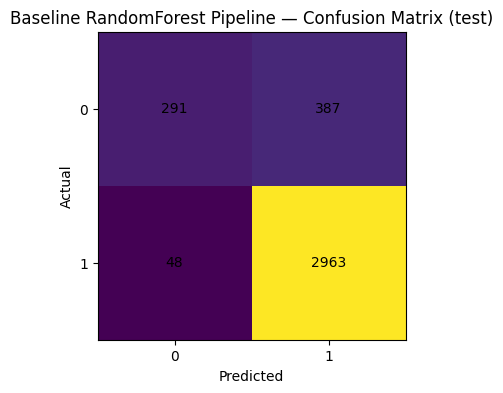

In [31]:
baseline_metrics, baseline_cm = evaluate_classifier(
    model_pipeline, X_train, y_train, X_test, y_test, label="Baseline RandomForest Pipeline"
)

##### The model shows approximately 88.20% accuracy. Next, we will fine tune the model looking for the best set of parameters.

# Fine-Tuning Pipeline
* Use a parameter search to better adjust the model.

#### Set parameters

In [32]:
# Set Parameters to randomly search over
my_distributions = dict(
    randomforestclassifier__max_features=[
        100,
        150,
        250,
    ],
    randomforestclassifier__n_estimators=[
        150,
        200,
    ],
)


#### Define parameter search

In [33]:
# Define parameter search combinations
param_search = RandomizedSearchCV(
    estimator = model_pipeline,
    param_distributions = my_distributions,
    n_iter=6,
    cv=5,
    n_jobs=1,
    refit=True,
    verbose=3,
    random_state=42,
)


#### Fit parameter search on training data samples, 30 fits total

In [34]:
# Search using sample of training data
# To fit on all training data, use param_search.fit(X_train, y_train)
# Use time to determine approximate fit time
start = time.time()
print(f"Start time: {start}") 
param_search.fit(X_train, y_train)  # fit on sample
end = time.time()


Start time: 1766060563.680414
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=150;, score=0.888 total time= 1.9min
[CV 2/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=150;, score=0.885 total time= 1.8min
[CV 3/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=150;, score=0.876 total time= 1.8min
[CV 4/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=150;, score=0.884 total time= 1.8min
[CV 5/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=150;, score=0.886 total time= 1.8min
[CV 1/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=200;, score=0.887 total time= 1.9min
[CV 2/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=200;, score=0.885 total time= 1.8min
[CV 3/5

In [35]:
# Display how long it took to search
param_fit_time = (end - start) / 60
print(f"It took: {param_fit_time:.2f} minutes for 30 fits")

It took: 57.39 minutes for 30 fits


#### Retrieve the determined best parameters modeling

In [36]:
# Retrieve the best parameters
param_search.best_params_

{'randomforestclassifier__n_estimators': 150,
 'randomforestclassifier__max_features': 250}

#### The best parameters for this model are: 'n_estimators' = 150 and 'max_features' = 250

In [37]:
# Retreive the best model
model_best = param_search.best_estimator_
model_best

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('randomforestclassifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of th

#### Finally, Test the accuracy of the determined best model and compare to original model


=== Tuned RandomForest Pipeline: train vs test ===


,accuracy,precision,recall,f1
train,1.000000,1.000000,1.000000,1.000000
test,0.891298,0.904777,0.968781,0.935686



Test classification report:
              precision    recall  f1-score   support

           0     0.7978    0.5472    0.6492       678
           1     0.9048    0.9688    0.9357      3011

    accuracy                         0.8913      3689
   macro avg     0.8513    0.7580    0.7924      3689
weighted avg     0.8851    0.8913    0.8830      3689



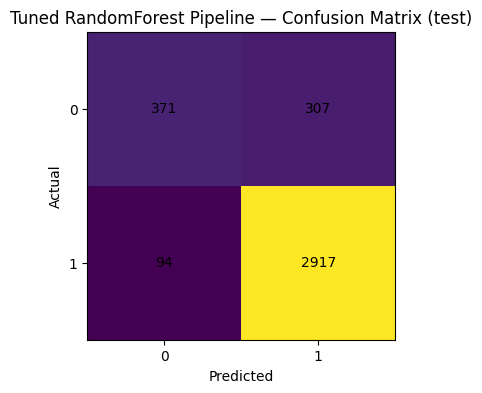

In [38]:
# Test the accuracy of the determined best model
best_metrics, best_cm = evaluate_classifier(
    model_best, X_train, y_train, X_test, y_test, label="Tuned RandomForest Pipeline"
)


#### The best model is slightly more accurate at approximately 89.1% accuracy.

## Plot the most important features
* To plot the most important features, we need all feature names from the pipeline

#### Get feature names from pipeline

In [39]:
# Get the steps in the column transformer to retrieve the individual feature pipelines
col_trans = model_pipeline.named_steps['columntransformer']

# 'cat' is the categorical pipeline
cat_pipeline = col_trans.named_transformers_['cat']

# Get feature names for the 4 categorical input columns
cat_names = cat_pipeline.named_steps['cat_encoder'].get_feature_names_out(['Clothing ID', 'Division Name', 'Department Name', 'Class Name'])

# 'text' is the text feature union in the pipeline
text_FU = col_trans.named_transformers_['text']

# Get the tfidf pipeline feature names
tfidf_names = text_FU.transformer_list[0][1].named_steps['tfidf_vectorizer'].get_feature_names_out()
tfidf_names = [f"tfidf_{name}" for name in tfidf_names]  # add tfidf to know it is a tfidf feature

# Get feature name for senitment
sent_names = ['TransformerSentimentScorer_score']

# Get nlp names
nlp_names = ['pos_nouns', 'pos_verbs', 'pos_adjectives', 'ner_entities']

# Use num_features for num_names
num_names = num_features

# Create a list of all feature names
all_feature_names = num_names + list(cat_names) + list(tfidf_names) + sent_names + nlp_names


#### Get feature importances from model_

In [40]:
# Get feature importances 
importances = model_pipeline.named_steps['randomforestclassifier'].feature_importances_

# Create sorted pandas Series using importances and all_feature_names
feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)


#### Plot the most important features using a bar graph

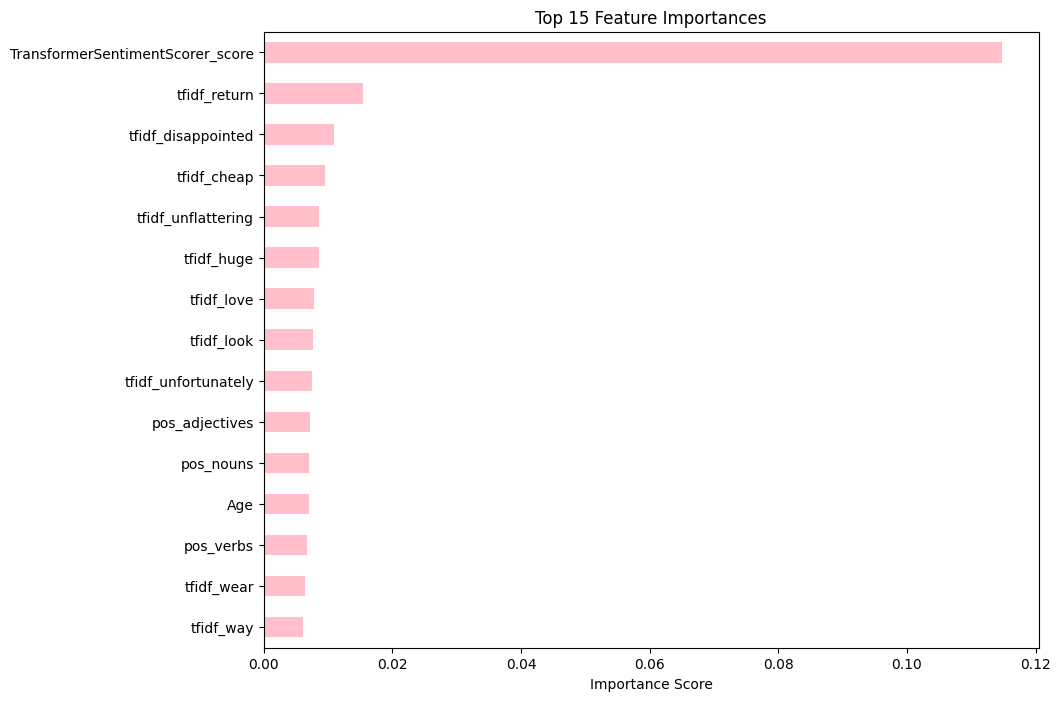

In [41]:
# Plot the top 15 most important features in a bar graph
plt.figure(figsize=(10, 8))
feat_imp.head(15).plot(kind='barh', color='pink')
plt.xlabel('Importance Score')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.show()


#### The plot shows the most important feature by far is 'TransformerSentimentScorer score', followed by multiple tfidf words (term frequency), age as the 9th most important feature followed pos features and more tfidf words.